<a href="https://colab.research.google.com/github/ramyasnl/TensorFlowUdacity/blob/main/ScaNNwithGloVe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##ScaNN Algorithms and Configuration
ScaNN supports several vector search techniques, each with their own tuning parameters. This page explains the basics of the various techniques.

##ScaNN performs vector search in three phases. They are described below:

## Partitioning (optional): ScaNN partitions the dataset during training time, and at query time selects the top partitions to pass onto the scoring stage.
Scoring: ScaNN computes the distances from the query to all datapoints in the dataset (if partitioning isn't enabled) or all datapoints in a partition to search (if partitioning is enabled). These distances aren't necessarily exact.
Rescoring (optional): ScaNN takes the best k' distances from scoring and re-computes these distances more accurately. From these k' re-computed distances the top k are selected.
All three phases can be configured through the ScaNNBuilder class. Before going into details, below are some general guidelines for ScaNN configuration.

## Rules-of-thumb
For a small dataset (fewer than 20k points), use brute-force.
For a dataset with less than 100k points, score with AH, then rescore.
For datasets larger than 100k points, partition, score with AH, then rescore.
When scoring with AH, dimensions_per_block should be set to 2.
When partitioning, num_leaves should be roughly the square root of the number of datapoints.
## Partitioning
Partitioning is configured through .tree(...). The most important parameters are num_leaves and num_leaves_to_search. The higher num_leaves, the higher-quality the partitioning will be; however, raising this parameter also makes partitioning take longer. num_leaves_to_search / num_leaves determines the proportion of the dataset that is pruned. Raising this proportion increases accuracy but leads to more points being scored and therefore less speed.

If a dataset has n points, the number of partitions should generally be the same order of magnitude as sqrt(n) for a good balance of partitioning quality and speed. num_leaves_to_search should be tuned based on recall target.

## Scoring
Scoring can either be done with brute-force or asymmetric hashing (AH). The corresponding functions in ScannBuilder are score_brute_force and score_ah. Unless near-perfect accuracy is required, AH gives better speed/accuracy tradeoffs. See Product quantization for nearest neighbor search and Gersho and Gray's Vector Quantization and Signal Compression for background on AH, and Accelerating Large-Scale Inference with Anisotropic Quantization for an academic descrition of anisotropic_quantization_threshold. We recommend setting dimensions_per_block to 2.

The only parameter for brute-force scoring is quantize. If enabled, this quantizes each dimension of each datapoint into an 8-bit integer. This is a 4x compression ratio over 32-bit floats and can therefore quarter the latency in memory-bandwidth bound scenarios. However, quantized brute force is slower than full brute force in non-memory bandwidth bound scenarios, which occur when the batch size is sufficiently large or when the dataset is small enough to fit into cache. Quantized brute-force generally leads to negligible accuracy losses over full brute force.

## Rescoring
Rescoring is highly recommended if AH scoring is used. reordering_num_neighbors should be greater than k, the final number of neighbors. Raising reordering_num_neighbors increases accuracy at the cost of speed. quantize has the same meaning as in brute-force scoring.

# ScaNN Demo with GloVe Dataset

In [2]:
! pip install scann

     |████████████████████████████████| 10.9 MB 135 kB/s 


In [3]:
import numpy as np
import h5py
import os
import requests
import tempfile
import time
import scann

## Download dataset

In [4]:
with tempfile.TemporaryDirectory() as tmp:
    response = requests.get("http://ann-benchmarks.com/glove-100-angular.hdf5")
    loc = os.path.join(tmp, "glove.hdf5")
    with open(loc, 'wb') as f:
        f.write(response.content)
    
    glove_h5py = h5py.File(loc, "r")

In [5]:
list(glove_h5py.keys())

['distances', 'neighbors', 'test', 'train']

In [6]:
dataset = glove_h5py['train']
queries = glove_h5py['test']
print(dataset.shape)
print(queries.shape)

(1183514, 100)
(10000, 100)


## Create ScaNN searcher

In [7]:
normalized_dataset = dataset / np.linalg.norm(dataset, axis=1)[:, np.newaxis]
# configure ScaNN as a tree - asymmetric hash hybrid with reordering
# anisotropic quantization as described in the paper; see README

# use scann.scann_ops.build() to instead create a TensorFlow-compatible searcher
searcher = scann.scann_ops_pybind.builder(normalized_dataset, 10, "dot_product").tree(
    num_leaves=2000, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

In [8]:
def compute_recall(neighbors, true_neighbors):
    total = 0
    for gt_row, row in zip(true_neighbors, neighbors):
        total += np.intersect1d(gt_row, row).shape[0]
    return total / true_neighbors.size

 ## ScaNN interface features

In [9]:
# this will search the top 100 of the 2000 leaves, and compute
# the exact dot products of the top 100 candidates from asymmetric
# hashing to get the final top 10 candidates.
start = time.time()
neighbors, distances = searcher.search_batched(queries)
end = time.time()

# we are given top 100 neighbors in the ground truth, so select top 10
print("Recall:", compute_recall(neighbors, glove_h5py['neighbors'][:, :10]))
print("Time:", end - start)

Recall: 0.90015
Time: 2.1374807357788086


In [10]:
# increasing the leaves to search increases recall at the cost of speed
start = time.time()
neighbors, distances = searcher.search_batched(queries, leaves_to_search=150)
end = time.time()

print("Recall:", compute_recall(neighbors, glove_h5py['neighbors'][:, :10]))
print("Time:", end - start)

Recall: 0.92392
Time: 2.861952781677246


In [11]:
# increasing reordering (the exact scoring of top AH candidates) has a similar effect.
start = time.time()
neighbors, distances = searcher.search_batched(queries, leaves_to_search=150, pre_reorder_num_neighbors=250)
end = time.time()

print("Recall:", compute_recall(neighbors, glove_h5py['neighbors'][:, :10]))
print("Time:", end - start)

Recall: 0.93145
Time: 3.556142807006836


In [12]:
# we can also dynamically configure the number of neighbors returned
# currently returns 10 as configued in ScannBuilder()
neighbors, distances = searcher.search_batched(queries)
print(neighbors.shape, distances.shape)

# now returns 20
neighbors, distances = searcher.search_batched(queries, final_num_neighbors=20)
print(neighbors.shape, distances.shape)

(10000, 10) (10000, 10)
(10000, 20) (10000, 20)


In [13]:
# we have been exclusively calling batch search so far; the single-query call has the same API
start = time.time()
neighbors, distances = searcher.search(queries[0], final_num_neighbors=5)
end = time.time()

print(neighbors)
print(distances)
print("Latency (ms):", 1000*(end - start))

[ 97478 846101 671078 727732 544474]
[2.5518737 2.539792  2.5383418 2.5097368 2.4656374]
Latency (ms): 1.8646717071533203


## Reffer :  
https://github.com/google-research/google-research/tree/master/scann/docs

ScaNN
ScaNN (Scalable Nearest Neighbors) is a method for efficient vector similarity search at scale. This code release implements [1], which includes search space pruning and quantization for Maximum Inner Product Search and also supports other distance functions such as Euclidean distance. The implementation is designed for x86 processors with AVX2 support. ScaNN achieves state-of-the-art performance on ann-benchmarks.com as shown on the glove-100-angular dataset below:
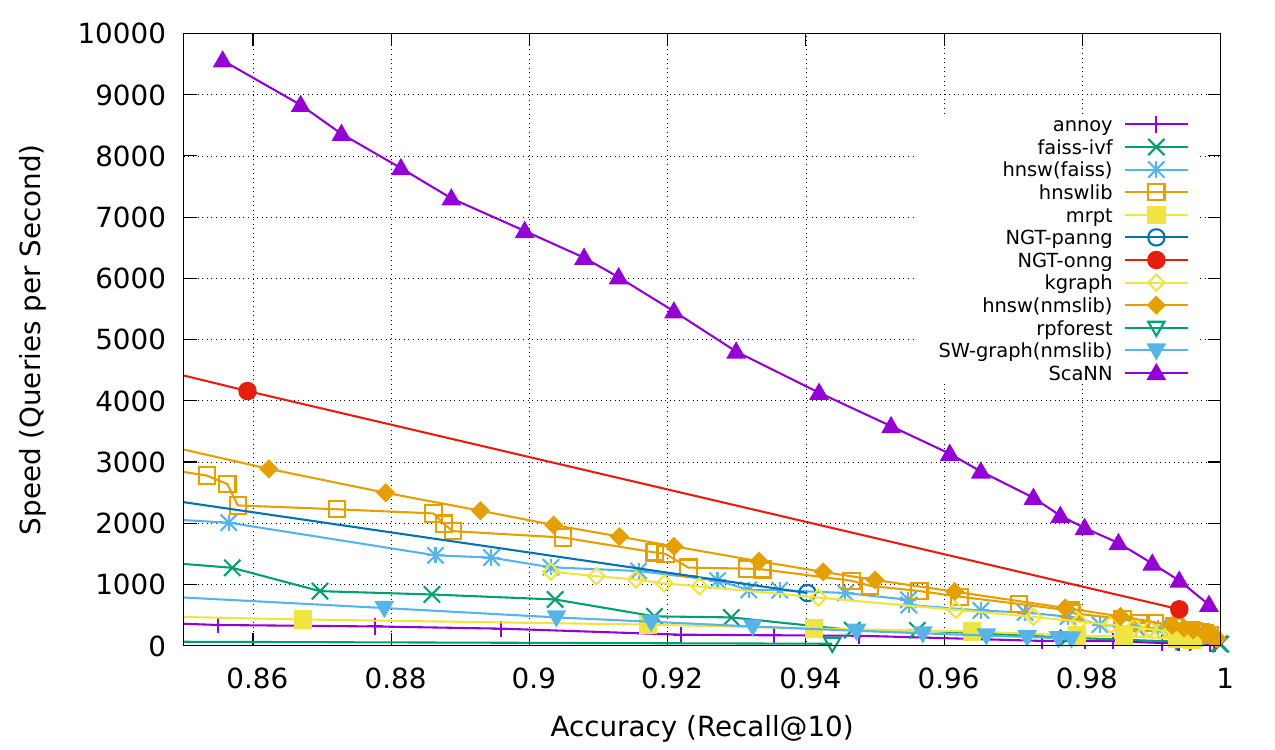

glove-100-angular

ScaNN can be configured to fit datasets with different sizes and distributions. It has both TensorFlow and Python APIs. The library shows strong performance with large datasets [1]. The code is released for research purposes. For more details on the academic description of algorithms, please see [1].

###Reference [1]:

@inproceedings{avq_2020,
  title={Accelerating Large-Scale Inference with Anisotropic Vector Quantization},
  author={Guo, Ruiqi and Sun, Philip and Lindgren, Erik and Geng, Quan and Simcha, David and Chern, Felix and Kumar, Sanjiv},
  booktitle={International Conference on Machine Learning},
  year={2020},
  URL={https://arxiv.org/abs/1908.10396}
}
###Installation
manylinux2014-compatible wheels are available on PyPI:

pip install scann
ScaNN supports Linux environments running Python versions 3.6-3.9. See docs/releases.md for release notes; the page also contains download links for ScaNN wheels prior to version 1.1.0, which were not released on PyPI.

In accordance with the manylinux2014 specification, ScaNN requires libstdc++ version 3.4.19 or above from the operating system. See here for an example of how to find your system's libstdc++ version; it can generally be upgraded by installing a newer version of g++.

Integration with TensorFlow Serving
We provide custom Docker images of TF Serving that are linked to the ScaNN TF ops. See the tf_serving directory for further information.

###Building from source
To build ScaNN from source, first install the build tool bazel, Clang 8, and libstdc++ headers for C++17 (which are provided with GCC 9). Additionally, ScaNN requires a modern version of Python (3.6.x or later) and Tensorflow 2.5 installed on that version of Python. Once these prerequisites are satisfied, run the following command in the root directory of the repository:

python configure.py
CC=clang-8 bazel build -c opt --features=thin_lto --copt=-mavx2 --copt=-mfma --cxxopt="-D_GLIBCXX_USE_CXX11_ABI=0" --cxxopt="-std=c++17" --copt=-fsized-deallocation --copt=-w :build_pip_pkg
./bazel-bin/build_pip_pkg
A .whl file should appear in the root of the repository upon successful completion of these commands. This .whl can be installed via pip.

